In [277]:
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, SpatialDropout1D, Conv1D, Lambda, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM
from tensorflow.keras.layers import BatchNormalization, AveragePooling2D, ZeroPadding2D
from tensorflow.keras.layers import Add
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.regularizers import l2
import tensorflow_addons as tfa
from tensorflow.keras.layers import MaxPool2D

from tensorflow.keras.datasets import mnist
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.datasets import cifar100
from tensorflow.keras import utils

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_json

from sklearn.model_selection import train_test_split
import collections

from tensorflow.keras.callbacks import TensorBoard

import tensorflow as tf

# importing of service libraries
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from albumentations import (
    Compose, RandomBrightness, JpegCompression, HueSaturationValue, RandomContrast, HorizontalFlip,
    Rotate
)
import tensorflow_datasets as tfds
from tensorflow.data import AUTOTUNE
from functools import partial
from tensorflow_addons.optimizers import AdamW
import os
import math

print('Libraries imported.')

Libraries imported.


In [278]:
fine_labels = [
    'apple',  # id 0
    'aquarium_fish',
    'baby',
    'bear',
    'beaver',
    'bed',
    'bee',
    'beetle',
    'bicycle',
    'bottle',
    'bowl',
    'boy',
    'bridge',
    'bus',
    'butterfly',
    'camel',
    'can',
    'castle',
    'caterpillar',
    'cattle',
    'chair',
    'chimpanzee',
    'clock',
    'cloud',
    'cockroach',
    'couch',
    'crab',
    'crocodile',
    'cup',
    'dinosaur',
    'dolphin',
    'elephant',
    'flatfish',
    'forest',
    'fox',
    'girl',
    'hamster',
    'house',
    'kangaroo',
    'computer_keyboard',
    'lamp',
    'lawn_mower',
    'leopard',
    'lion',
    'lizard',
    'lobster',
    'man',
    'maple_tree',
    'motorcycle',
    'mountain',
    'mouse',
    'mushroom',
    'oak_tree',
    'orange',
    'orchid',
    'otter',
    'palm_tree',
    'pear',
    'pickup_truck',
    'pine_tree',
    'plain',
    'plate',
    'poppy',
    'porcupine',
    'possum',
    'rabbit',
    'raccoon',
    'ray',
    'road',
    'rocket',
    'rose',
    'sea',
    'seal',
    'shark',
    'shrew',
    'skunk',
    'skyscraper',
    'snail',
    'snake',
    'spider',
    'squirrel',
    'streetcar',
    'sunflower',
    'sweet_pepper',
    'table',
    'tank',
    'telephone',
    'television',
    'tiger',
    'tractor',
    'train',
    'trout',
    'tulip',
    'turtle',
    'wardrobe',
    'whale',
    'willow_tree',
    'wolf',
    'woman',
    'worm',
]

In [279]:
def load_cifar100():
    print('Loading CIFAR-100 dataset...')
    (X_train, y_train), (X_test, y_test) = cifar100.load_data()
    print('CIFAR-100 dataset loaded.')
    true_labels = fine_labels
    return (X_train, y_train), (X_test, y_test), true_labels

def view_image(ds):
    image, label = next(iter(ds)) # extract 1 batch from the dataset
    image = image.numpy()
    label = label.numpy()
    
    fig = plt.figure(figsize=(22, 22))
    for i in range(20):
        ax = fig.add_subplot(4, 5, i+1, xticks=[], yticks=[])
        ax.imshow(image[i])
        ax.set_title(f"Label: {label[i]}")

In [280]:
# CIFAR_100 is a set of 60K images 32x32 pixels on 3 channels
IMG_CHANNELS = 3
IMG_ROWS = 32
IMG_COLS = 32
N_CLASSES = 100
print('Image variables initialisation')

Image variables initialisation


In [281]:
(X_train, y_train), (X_test, y_test), true_labels = load_cifar100()

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

#convert to categorical
Y_train = utils.to_categorical(y_train, N_CLASSES)
Y_test = utils.to_categorical(y_test, N_CLASSES)

#float and normalise
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255



Loading CIFAR-100 dataset...
CIFAR-100 dataset loaded.
X_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


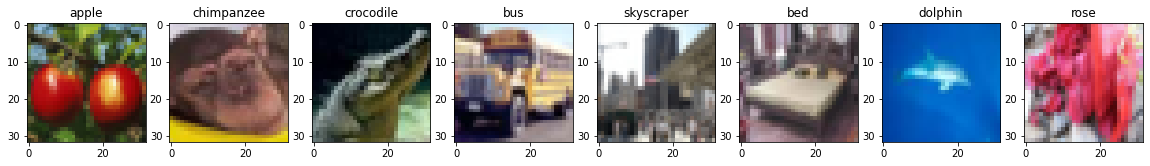

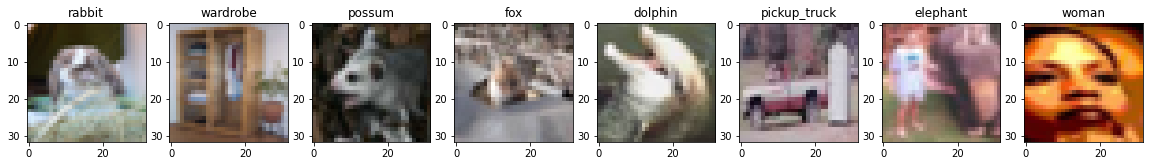

In [282]:
# display 8 random images
selected_images = np.random.choice(X_train.shape[0], 8)
(fig, ax) = plt.subplots(1, 8, figsize=(20, 5))
for i in range(len(selected_images)):
    image = X_train[selected_images[i]]
    ax[i].imshow(image)
    ax[i].set_title(true_labels[y_train[selected_images[i]][0]])
plt.show()

selected_images = np.random.choice(X_test.shape[0], 8)
(fig, ax) = plt.subplots(1, 8, figsize=(20, 5))
for i in range(len(selected_images)):
    image = X_test[selected_images[i]]
    ax[i].imshow(image)
    ax[i].set_title(true_labels[y_test[selected_images[i]][0]])
plt.show()


In [283]:
class ResnetBlock(Model):
    """
    A standard resnet block.
    """

    def __init__(self, channels: int, stride=1, down_sample=False):
        """
        channels: same as number of convolution kernels
        """
        super().__init__()

        self.__channels = channels
        self.__down_sample = down_sample
        self.stride = stride

        # use He initialization, instead of Xavier (a.k.a 'glorot_uniform' in Keras), as suggested in [2]
        INIT_SCHEME = "he_normal"

        self.conv_1 = Conv2D(self.__channels, kernel_size=3, strides=1, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_1 = BatchNormalization()
        self.conv_2 = Conv2D(self.__channels, kernel_size=3, strides=1, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_2 = BatchNormalization()
        self.merge = Add()

        if self.__down_sample:
            # perform down sampling using stride of 2, according to [1].
            self.res_conv = Conv2D(self.__channels, kernel_size=1, strides=1, kernel_initializer=INIT_SCHEME, padding="same")
            self.res_bn = BatchNormalization()

    def call(self, inputs):
        res = inputs
        # print("X and res input shape ",res.shape)
        x = self.conv_1(inputs)
        # print("Conv1 ",x.shape)
        x = self.bn_1(x)
        # print("bn1 ",x.shape)
        x = tf.nn.relu(x)
        # print("relu ",x.shape)
        x = self.conv_2(x)
        # print("Conv2 ",x.shape)
        x = self.bn_2(x)
        # print("bn2 ",x.shape)

        if self.__down_sample:
            res = self.res_conv(res)
            # print("Res conv ",x.shape)
            res = self.res_bn(res)
            # print("Res bn ",x.shape)

        # if not perform down sample, then add a shortcut directly
        # print("before merge x ",x.shape)
        # print("before merge res ",res.shape)
        x = self.merge([x, res])
        out = tf.nn.relu(x)
        return out


class ResNet18(Model):

    def __init__(self, num_classes, DROPOUT, **kwargs):
        """
            num_classes: number of classes in specific classification task.
        """
        super().__init__(**kwargs)
        self.conv_1 = Conv2D(32, kernel_size=3, strides=1, padding="same", kernel_initializer="he_normal")
        self.init_bn = BatchNormalization()
        self.pool_2 = MaxPool2D(pool_size=(2, 2), strides=2, padding="same")

        self.res_1_1 = ResnetBlock(32, stride=1)
        self.res_1_2 = ResnetBlock(32, stride=1)

        self.res_2_1 = ResnetBlock(64, down_sample=True)
        self.res_2_2 = ResnetBlock(64, stride=1)

        self.res_3_1 = ResnetBlock(128, down_sample=True)
        self.res_3_2 = ResnetBlock(128, stride=1)

        self.res_4_1 = ResnetBlock(256, down_sample=True)
        self.res_4_2 = ResnetBlock(256, stride=1)
        
        self.avg_pool = GlobalAveragePooling2D()
        self.flat = Flatten()
        self.drop = Dropout(0.5)
        self.fc = Dense(num_classes, activation="softmax")

    def call(self, inputs):
        out = self.conv_1(inputs)
        out = self.init_bn(out)
        out = tf.nn.relu(out)
        out = self.pool_2(out)
        for res_block in [self.res_1_1, self.res_1_2, self.res_2_1, self.res_2_2, self.res_3_1, self.res_3_2, self.res_4_1, self.res_4_2]:
            out = res_block(out)
        out = self.avg_pool(out)
        out = self.flat(out)
        out = self.drop(out)
        out = self.fc(out)
        return out

In [284]:
def define_model_cnn(LEARNING_RATE, DECAY, DROPOUT, MOMENTUM, OPTIMIZER):
    model = Sequential()
 
    model.add(Conv2D(32, kernel_size=3, padding='same', input_shape=(IMG_ROWS, IMG_COLS, IMG_CHANNELS)))
    model.add(Activation('relu'))
    model.add(Conv2D(32, kernel_size=3, padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, kernel_size=3, padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, 3, 3))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(N_CLASSES))
    model.add(Activation('softmax'))

    if OPTIMIZER == "SGD":
        optim = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    elif OPTIMIZER == "RMS":
        optim = RMSprop()
    model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])

    model.summary()
    return model

def define_model_resnet18(LEARNING_RATE, DECAY, DROPOUT, MOMENTUM, OPTIMIZER):

    # model = resnet18([IMG_ROWS, IMG_COLS, IMG_CHANNELS], N_CLASSES)
    
    model = ResNet18(100, DROPOUT)
    model.build(input_shape = (None,32,32,3))

    # optim = SGD(lr=LEARNING_RATE, decay=DECAY, momentum=MOMENTUM, nesterov=True)
    optim = AdamW(learning_rate=LEARNING_RATE, weight_decay=DECAY)
    model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])

    
    # model.compile(optimizer = "adam", loss='categorical_crossentropy', metrics=["accuracy"]) 
    model.summary()

    return model


In [285]:
def create_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

def save_text_file(file_name, text):
    with open(file_name, 'w') as f:
        for line in text:
            f.write(line + '\n')

def tensorboard_log_dir(log_dir):
    return os.path.join('logs', log_dir)


def run_experiment(name, N_EPOCH, BATCH_SIZE, LEARNING_RATE, DECAY, OPTIMIZER, DROPOUT, MOMENTUM=0.9, datagen_bool=False):
    tensorboard = TensorBoard(log_dir='lab/'+tensorboard_log_dir(name), histogram_freq=0, write_graph=True, write_images=False)

    model = define_model_resnet18(LEARNING_RATE, DECAY, DROPOUT, MOMENTUM, OPTIMIZER)

    create_directory("lab/" + name)

    text = ['##### START EXPERIMENT: ' + name + ' #####\n']

    text = text + ['##### PARAMETERS #####']
    text = text + ['EPOCHS:        ' + str(N_EPOCH)]
    text = text + ['BATCH_SIZE:    ' + str(BATCH_SIZE)]
    text = text + ['LEARNING RATE: ' + str(LEARNING_RATE)]

    if not datagen_bool:
        
        history = model.fit(X_train, Y_train, batch_size=BATCH_SIZE, epochs=N_EPOCH, validation_split=VALIDATION_SPLIT, verbose=VERBOSE, callbacks=[tensorboard])

        text = text + ["\nTrain Accuracy:            " + str(history.history['accuracy'][-1])]
        text = text + ["Train Validation Accuracy: " + str(history.history['val_accuracy'][-1])]
        text = text + ["\nTrain Loss:                " + str(history.history['loss'][-1])]
        text = text + ["Train Validation Loss:     " + str(history.history['val_loss'][-1])]

        #Testing
        score = model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE, verbose=VERBOSE)
        # print("\nTest score/loss:", score[0])
        # print('Test accuracy:', score[1])
        text = text + ['\nTest accuracy:             ' + str(score[1])]
        text = text + ['Test score/loss:           ' + str(score[0])]

        # list all data in history
        # print(history.history.keys())

        # summarize history for accuracy
        #plt.plot(mo)
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.savefig('lab/'+name+'/' + name + '_accuracy.png')
        plt.clf()

        # summarize history for loss
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='lower left')
        plt.savefig('lab/'+name+'/' + name + '_loss.png')
        plt.clf()

    else:
        pass
        # history_datagen = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE), steps_per_epoch=X_train.shape[0]//BATCH_SIZE, epochs=N_EPOCH, verbose=VERBOSE)
        # text = text + ["\n\nDATAGEN Train Accuracy:    " + str(history_datagen.history['accuracy'][-1])]
        # text = text + ["DATAGEN Train Loss:        " + str(history_datagen.history['loss'][-1])]

        # #Testing
        # score_datagen = model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE, verbose=VERBOSE)
        # # print("\nTest score/loss:", score[0])
        # # print('Test accuracy:', score[1])
        # text = text + ['\nDATAGEN Test accuracy:     ' + str(score_datagen[1])]
        # text = text + ['DATAGEN Test score/loss:   ' + str(score_datagen[0]) + '\n']

        # # list all data in history
        # # print(history_datagen.history.keys())

        # # summarize history for accuracy
        # #plt.plot(mo)
        # plt.plot(history_datagen.history['accuracy'])
        # plt.title('model accuracy')
        # plt.ylabel('accuracy')
        # plt.xlabel('epoch')
        # plt.legend(['train'], loc='upper left')
        # plt.savefig('lab/'+name+'/' + name + '_accuracy_datagen.png')
        # plt.clf()

        # # summarize history for loss
        # plt.plot(history_datagen.history['loss'])
        # plt.title('model loss')
        # plt.ylabel('loss')
        # plt.xlabel('epoch')
        # plt.legend(['train'], loc='upper left')
        # plt.savefig('lab/'+name+'/' + name + '_loss_datagen.png')
        # plt.clf()

    text = text + ["\n##### END EXPERIMENT: " + name + " #####"]

    save_text_file('lab/'+name+'/' + name + '.txt', text)

    return [name, history.history['accuracy'][-1], history.history['val_accuracy'][-1], history.history['loss'][-1], history.history['val_loss'][-1], score[1], score[0]]


# datagen = ImageDataGenerator(
#         featurewise_center=True,  # set input mean to 0 over the dataset
#         samplewise_center=True,  # set each sample mean to 0
#         featurewise_std_normalization=True,  # divide inputs by std of the dataset
#         samplewise_std_normalization=True,  # divide each input by its std
#         zca_whitening=True,  # apply ZCA whitening
#         rotation_range=180,  # randomly rotate images in the range (degrees, 0 to 180)
#         width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
#         height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
#         horizontal_flip=True,  # randomly flip images
#         vertical_flip=True)  # randomly flip images

# #fit the dataset
# datagen.fit(X_train)




In [286]:
VERBOSE = 1
VALIDATION_SPLIT = 0.2

# N_EPOCH = 1
# BATCH_SIZE = 256
# LEARNING_RATE = 0.01
# OPTIM = RMSprop()
# DROPOUT_RATE = 0.5

In [287]:
batch_exp = []
lr_exp = []

# print("Experiment 1:")
# batch_exp.append(run_experiment('resnet model batch 32', 25, 32, 0.001, datagen_bool=False))
# print("Experiment 2:")
# batch_exp.append(run_experiment('resnet model batch 64', 25, 64, 0.001, datagen_bool=False))
# print("Experiment 3:")
# batch_exp.append(run_experiment('resnet model batch 128', 25, 128, 0.001, datagen_bool=False))
# print("Experiment 3:")
# batch_exp.append(run_experiment('resnet model batch 256', 25, 256, 0.001, datagen_bool=False))

# print("Experiment 5:")
# lr_exp.append(run_experiment('resnet model lr 0.1', 25, 256, 0.1, datagen_bool=False))
# print("Experiment 6:")
# lr_exp.append(run_experiment('resnet model lr 0.01', 25, 256, 0.01, datagen_bool=False))
# print("Experiment 7:")
# lr_exp.append(run_experiment('resnet model lr 0.001', 25, 256, 0.001, datagen_bool=False))
# print("Experiment 8:")
# lr_exp.append(run_experiment('resnet model lr 0.0001', 25, 256, 0.0001, datagen_bool=False))





In [288]:
print("Experiment test:")
# batch_exp.append(run_experiment('resnet model test', N_EPOCH=100, BATCH_SIZE=512, LEARNING_RATE=1e-3, DECAY=1e-4, MOMENTUM=0.9, datagen_bool=False))

# print(run_experiment('deeper cnn model SGD', N_EPOCH=100, BATCH_SIZE=512, LEARNING_RATE=2e-3, DECAY=1e-3, MOMENTUM=0.9, DROPOUT=0.5, datagen_bool=False, OPTIMIZER="SGD"))
# print(run_experiment('deeper cnn model RMS', N_EPOCH=100, BATCH_SIZE=512, LEARNING_RATE=2e-3, DECAY=1e-3, MOMENTUM=0.9, DROPOUT=0.5, datagen_bool=False, OPTIMIZER="RMS"))
batch_exp.append(run_experiment('resnet trial 11', N_EPOCH=200, BATCH_SIZE=256, LEARNING_RATE=1e-3, DECAY=1e-4, MOMENTUM=0.9, DROPOUT=0.5, datagen_bool=False, OPTIMIZER="ADAM"))


Experiment test:
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "res_net18_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_480 (Conv2D)         multiple                  896       
                                                                 
 batch_normalization_480 (Ba  multiple                 128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_23 (MaxPoolin  multiple                 0         
 g2D)                                                            
                                                                 
 resnet_block_184 (ResnetBl

KeyboardInterrupt: 